In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [2]:
warnings.filterwarnings("ignore")
sns.set()

In [3]:
df = pd.read_csv('jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# **Plot original series**

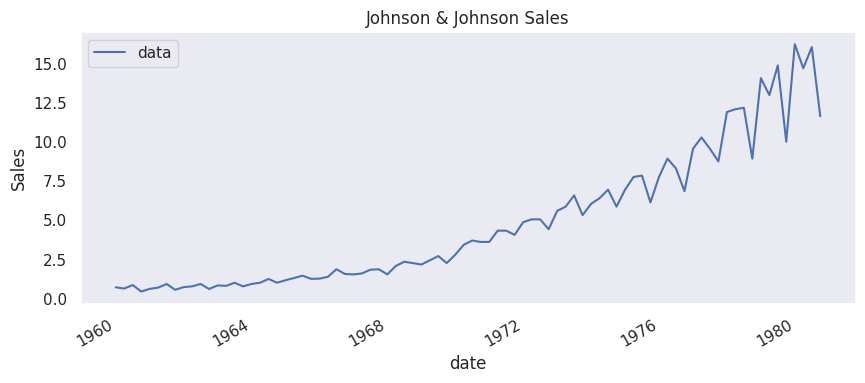

In [5]:
df.plot(figsize=(10, 4), title="Johnson & Johnson Sales", ylabel='Sales')
plt.grid()
plt.show()

# **Check stationarity**

In [7]:
result = adfuller(df['data'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 2.7420165734574744
p-value: 1.0


In [12]:
df_diff = df.diff().dropna()
result_diff = adfuller(df_diff['data'])
print(f"\nAfter Differencing:")
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")


After Differencing:
ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


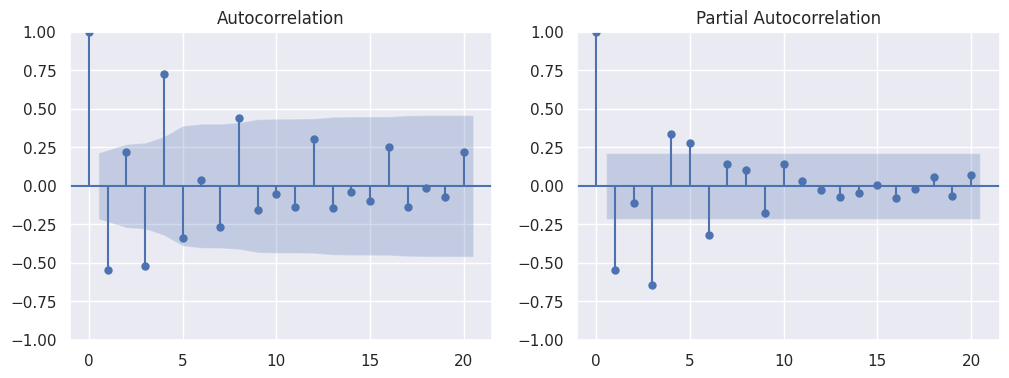

In [13]:
# Plot ACF and PACF
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df_diff, ax=ax[0])
plot_pacf(df_diff, ax=ax[1])
plt.show()

# **ARIMA Model (auto selection based on ACF/PACF)**

In [15]:
model = ARIMA(df['data'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -128.371
Date:                Tue, 08 Apr 2025   AIC                            262.742
Time:                        15:09:52   BIC                            269.998
Sample:                             0   HQIC                           265.657
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3277      0.090     -3.657      0.000      -0.503      -0.152
ma.L1         -0.4313      0.093     -4.662      0.000      -0.613      -0.250
sigma2         1.2819      0.164      7.814      0.0

# **Forecast 8 steps ahead (24 months)**

In [16]:
forecast = model_fit.forecast(steps=8)
forecast_dates = pd.date_range(df.index[-1], periods=9, freq='QS')[1:]
forecast_series = pd.Series(forecast, index=forecast_dates)

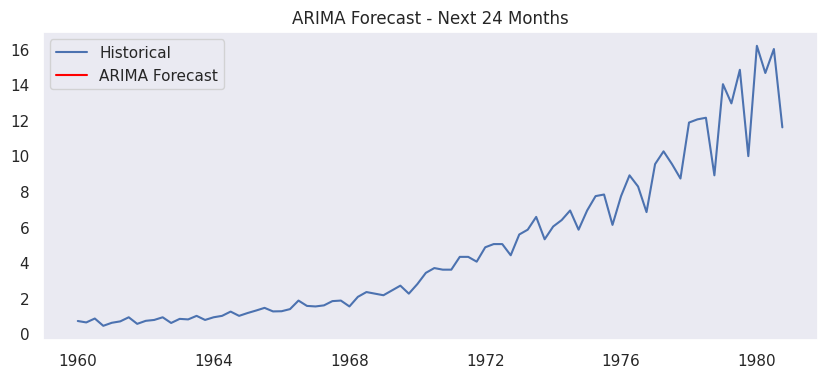

In [17]:
# Plot forecast
plt.figure(figsize=(10, 4))
plt.plot(df, label='Historical')
plt.plot(forecast_series, label='ARIMA Forecast', color='red')
plt.title("ARIMA Forecast - Next 24 Months")
plt.legend()
plt.grid()
plt.show()

In [18]:
# Evaluation (we simulate last 2 points as test)
train = df[:-2]
test = df[-2:]
model_eval = ARIMA(train, order=(1,1,1)).fit()
preds = model_eval.forecast(steps=2)

print("\nEvaluation:")
print("MAE:", mean_absolute_error(test, preds))
print("RMSE:", sqrt(mean_squared_error(test, preds)))


Evaluation:
MAE: 2.2453690364696053
RMSE: 2.329979000518956


# **RNN / LSTM Based Forecast**

In [19]:
# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

In [20]:
# Create sequences
def create_sequences(data, window=4):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 4
X, y = create_sequences(scaled, window)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [21]:
# Train/Test split
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [22]:
# Building LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model.fit(X_train, y_train, epochs=200, verbose=0)

In [23]:
# Evaluation
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

print("\nLSTM Model Evaluation:")
print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
print("RMSE:", sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step

LSTM Model Evaluation:
MAE: 1.8330939250335692
RMSE: 1.982993865542118


In [24]:
# Forecast next 24 months (8 steps)
last_seq = scaled[-window:]
future_preds = []
input_seq = last_seq.copy()

for _ in range(8):
    pred = model.predict(input_seq.reshape(1, window, 1))
    future_preds.append(pred[0,0])
    input_seq = np.append(input_seq[1:], pred[0,0])

future_scaled = np.array(future_preds).reshape(-1, 1)
future_forecast = scaler.inverse_transform(future_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


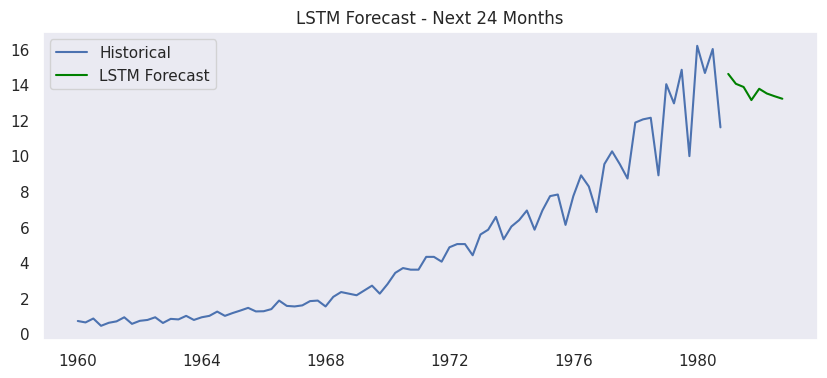

In [25]:
# Plot
forecast_rnn = pd.Series(future_forecast.flatten(), index=forecast_dates)
plt.figure(figsize=(10, 4))
plt.plot(df, label='Historical')
plt.plot(forecast_rnn, label='LSTM Forecast', color='green')
plt.title("LSTM Forecast - Next 24 Months")
plt.legend()
plt.grid()
plt.show()